# Classification analysis

## Libraries and settings

In [289]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

# Show version of scikit-learn
import sklearn
sklearn.__version__

/workspaces/wine_analysis/notebooks


'1.6.0'

### Importing wine data

In [290]:
# Read and select variables
df_orig = pd.read_csv("/workspaces/wine_analysis/data/enriched/wine_data_enriched.csv")[['web-scraper-order',
                                                        'name',
                                                        'price',
                                                        'country',
                                                        'quantity',
                                                        'value',
                                                        'bio', 
                                                        'non_alcoholic', 
                                                        'premium', 
                                                        'wine_category', 
                                                        'price_category',
                                                        'price_per_10cl',
                                                        'quantity_in_cl',
                                                        'country_code',
                                                        'consumption_in_l',
                                                        ]]

# Remove duplicates
df_orig = df_orig.drop_duplicates()
df_orig.head(5)

# Remove missing values
df_orig = df_orig.dropna()
df_orig.head(5)

,web-scraper-order,name,price,country,quantity,value,bio,non_alcoholic,premium,wine_category,price_category,price_per_10cl,quantity_in_cl,country_code,consumption_in_l
0,1734709733-1,"NATURAPLAN BIO-PROSECCO DOC RAPHAEL DAL BO, EX...",11.95,Italien,75cl,1.59/10cl,1,0,0,SCHAUMWEIN,Mid-Range,1.59,75,ITA,4.83
1,1734709733-3,ZÜRICH AOC STAATSSCHREIBER CUVÉE BLANC PRESTIGE,12.70,Schweiz,75cl,1.69/10cl,0,0,1,WEISSWEIN,Mid-Range,1.69,75,CHE,4.35
2,1734709733-4,PROSECCO SUPERIORE DI VALDOBBIADENE CONEGLIANO...,10.95,Italien,75cl,1.46/10cl,0,0,1,SCHAUMWEIN,Mid-Range,1.46,75,ITA,4.83
3,1734709733-5,AIGLE LES MURAILLES CHABLAIS AOC H. BADOUX,22.50,Schweiz,70cl,3.21/10cl,0,0,0,UNCATEGORIZED,Mid-Range,3.21,70,CHE,4.35
4,1734709733-6,"CHAMPAGNE AOC CHARLES BERTIN, BRUT",19.50,Frankreich,75cl,2.60/10cl,0,0,0,SCHAUMWEIN,Mid-Range,2.60,75,FRA,6.44


## Barchart premium count by wine category

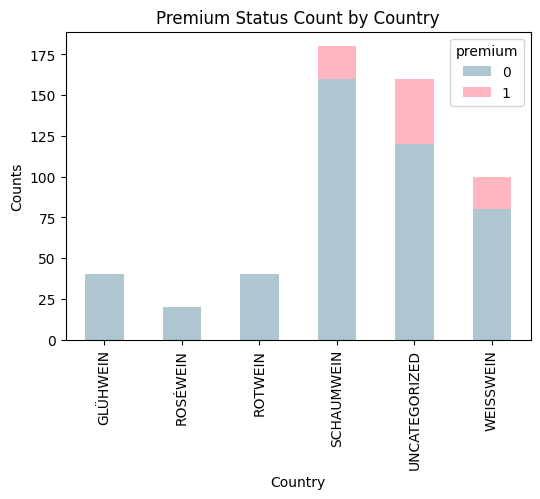

In [291]:
# Create a pivot table
table = df_orig[['wine_category', 'premium']].pivot_table(index='wine_category', 
                                        columns=['premium'], 
                                        aggfunc=len)

# Define pastel blue and pink colors
colors = ['#AEC6CF', '#FFB6C1']  # Light blue and light pink


# Plot a stacked bar chart
table.plot(kind='bar', 
           stacked=True, 
           ylabel='Counts', 
           xlabel='Country',
           title='Premium Status Count by Country', 
           rot=90,
           figsize=(6,4),
           color=colors ) # Use custom colors)

plt.show()

## Create numeric variable for 'price_category'

In [292]:
# Ordinal Encoding für 'price_category'
price_category_mapping = {'Budget': 0, 'Mid-Range': 1, 'Premium': 2}
df_orig['price_category_encoded'] = df_orig['price_category'].map(price_category_mapping)


## Pivot table

In [293]:
pd.pivot_table(
    df_orig[['premium', 'consumption_in_l', 'price_category', 'price']],
    index=['premium', 'price_category'],
    values=['price', 'consumption_in_l'],
    aggfunc=(np.mean, 'count')
).round(0)


consumption_in_l      price      
                                  count mean count  mean
premium price_category                                  
0       Budget                      180  5.0   180   8.0
        Mid-Range                   240  5.0   240  16.0
        Premium                      40  5.0    40  41.0
1       Budget                       20  5.0    20  10.0
        Mid-Range                    40  5.0    40  12.0
        Premium                      20  4.0    20  42.0

## Classification Tree


### Create train and test samples (train = 80%, test = 20% of the data)

In [294]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_orig[['price_per_10cl', 
                                                             'bio', 
                                                             'non_alcoholic',
                                                             'premium', 
                                                             'consumption_in_l',
                                                             'price_category_encoded']]
, 
                                                                df_orig['wine_category'], 
                                                                test_size=0.50, 
                                                                random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
     price_per_10cl  bio  non_alcoholic  premium  consumption_in_l  \
111            3.21    0              0        0              4.35   
290            0.93    0              0        0              3.52   
354            3.21    0              0        0              4.35   
262            1.33    0              0        0              4.83   
399            5.13    0              0        0              6.44   

     price_category_encoded  
111                       1  
290                       0  
354                       1  
262                       0  
399                       2   

y_train:
111    UNCATEGORIZED
290       SCHAUMWEIN
354    UNCATEGORIZED
262       SCHAUMWEIN
399       SCHAUMWEIN
Name: wine_category, dtype: object


### Fit the classification tree model and make predictions

In [295]:
# Initialize the classification tree model 
clf = DecisionTreeClassifier(random_state=20, 
                             max_depth=3)

# Train the classification tree model 
clf = clf.fit(X_train, y_train)

# Make model predictions
y_pred = clf.predict(X_test)
y_pred

array(['UNCATEGORIZED', 'UNCATEGORIZED', 'UNCATEGORIZED', 'SCHAUMWEIN',
       'UNCATEGORIZED', 'ROSÉWEIN', 'SCHAUMWEIN', 'UNCATEGORIZED',
       'SCHAUMWEIN', 'SCHAUMWEIN', 'UNCATEGORIZED', 'UNCATEGORIZED',
       'SCHAUMWEIN', 'SCHAUMWEIN', 'UNCATEGORIZED', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'SCHAUMWEIN', 'UNCATEGORIZED', 'UNCATEGORIZED',
       'SCHAUMWEIN', 'ROSÉWEIN', 'UNCATEGORIZED', 'SCHAUMWEIN',
       'SCHAUMWEIN', 'UNCATEGORIZED', 'SCHAUMWEIN', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'UNCATEGORIZED', 'SCHAUMWEIN', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'SCHAUMWEIN', 'UNCATEGORIZED', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'SCHAUMWEIN', 'SCHAUMWEIN', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'UNCATEGORIZED', 'SCHAUMWEIN', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'UNCATEGORIZED', 'UNCATEGORIZED', 'SCHAUMWEIN',
       'SCHAUMWEIN', 'UNCATEGORIZED', 'UNCATEGORIZED', 'UNCATEGORIZED',
       'UNCATEGORIZED', 'UNCATEGORIZED', 'SCHAUMWEIN', 'UNCATEGORIZED',
       'ROSÉWEIN'

### Show confusion matrix and classification report

In [296]:
# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred), '\n')

# Classification report
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[ 7  0  0  9  0  0]
 [ 0  9  0  0  0  0]
 [ 0  0  0  0 18  0]
 [ 0  0  0 63 27  0]
 [ 0  0  0 14 66  0]
 [ 0  0  0 13 44  0]] 

Classification report
               precision    recall  f1-score   support

     GLÜHWEIN       1.00      0.44      0.61        16
     ROSÉWEIN       1.00      1.00      1.00         9
      ROTWEIN       0.00      0.00      0.00        18
   SCHAUMWEIN       0.64      0.70      0.67        90
UNCATEGORIZED       0.43      0.82      0.56        80
    WEISSWEIN       0.00      0.00      0.00        57

     accuracy                           0.54       270
    macro avg       0.51      0.49      0.47       270
 weighted avg       0.43      0.54      0.46       270



### Print text representation of the classification tree

In [297]:
# Text representation of the classification tree
text_rep = tree.export_text(clf, 
                            feature_names=list(X_train.columns))

# Print text_representation
print(text_rep)

|--- price_per_10cl <= 0.99
|   |--- price_category_encoded <= 1.00
|   |   |--- price_per_10cl <= 0.96
|   |   |   |--- class: SCHAUMWEIN
|   |   |--- price_per_10cl >  0.96
|   |   |   |--- class: GLÜHWEIN
|   |--- price_category_encoded >  1.00
|   |   |--- class: ROSÉWEIN
|--- price_per_10cl >  0.99
|   |--- bio <= 0.50
|   |   |--- consumption_in_l <= 6.24
|   |   |   |--- class: UNCATEGORIZED
|   |   |--- consumption_in_l >  6.24
|   |   |   |--- class: SCHAUMWEIN
|   |--- bio >  0.50
|   |   |--- class: SCHAUMWEIN



## Visualize the classification tree

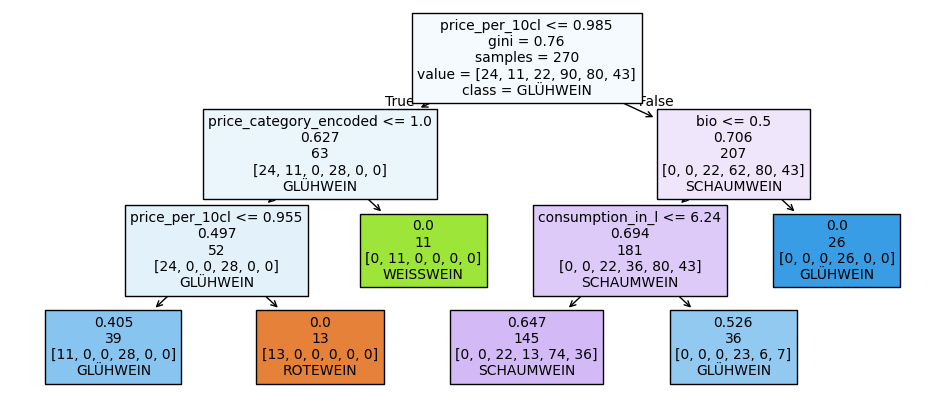

In [298]:
# For the meaning of numbers in boxes see root node
fig = plt.figure(figsize=(12,5))
tree_plot = tree.plot_tree(clf, 
                   feature_names=list(X_train.columns),  
                   class_names=['ROTEWEIN', 'WEISSWEIN', 'ROSÉWEIN', 'GLÜHWEIN', 'SCHAUMWEIN', 'UNCATEGORIZED'],
                   filled=True,
                   fontsize=10,
                   label='root')

## Random Forest Classifier

### Create train and test samples (train = 80%, test = 20% of the data)

In [299]:
# Create train and test samples
X2_train, X2_test, y2_train, y2_test = train_test_split(df_orig[['price_per_10cl', 
                                                             'bio', 
                                                             'non_alcoholic',
                                                             'premium', 
                                                             'consumption_in_l',
                                                             'price_category_encoded']], 
                                                        df_orig['wine_category'], 
                                                        test_size=0.20, 
                                                        random_state=42,
                                                  )

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
     price_per_10cl  bio  non_alcoholic  premium  consumption_in_l  \
182            0.93    0              0        0              3.52   
244            1.69    0              0        1              4.35   
539            2.26    0              0        0              4.83   
390            0.98    0              0        0              6.44   
453            5.13    0              0        0              6.44   

     price_category_encoded  
182                       0  
244                       1  
539                       1  
390                       0  
453                       2   

y2_train:
182       SCHAUMWEIN
244        WEISSWEIN
539    UNCATEGORIZED
390         GLÜHWEIN
453       SCHAUMWEIN
Name: wine_category, dtype: object


### Fit the Random Forest Classifier

In [300]:
# Initialize the random forest classifier
rfc = RandomForestClassifier(random_state=20, max_depth=10)

# Train the random forest classifier
rfc = rfc.fit(X2_train, y2_train)

# Predict the target variable (wine categories)
y_pred_rf = rfc.predict(X2_test)

# Print the predicted target variable (wine categories)
print('Predicted target variable (wine categories):')
print(y_pred_rf)


Predicted target variable (wine categories):
['WEISSWEIN' 'SCHAUMWEIN' 'ROTWEIN' 'SCHAUMWEIN' 'UNCATEGORIZED'
 'ROSÉWEIN' 'SCHAUMWEIN' 'WEISSWEIN' 'UNCATEGORIZED' 'SCHAUMWEIN'
 'WEISSWEIN' 'ROTWEIN' 'SCHAUMWEIN' 'SCHAUMWEIN' 'SCHAUMWEIN' 'WEISSWEIN'
 'ROTWEIN' 'SCHAUMWEIN' 'WEISSWEIN' 'WEISSWEIN' 'WEISSWEIN' 'ROSÉWEIN'
 'WEISSWEIN' 'SCHAUMWEIN' 'SCHAUMWEIN' 'SCHAUMWEIN' 'UNCATEGORIZED'
 'WEISSWEIN' 'UNCATEGORIZED' 'UNCATEGORIZED' 'SCHAUMWEIN' 'UNCATEGORIZED'
 'SCHAUMWEIN' 'SCHAUMWEIN' 'UNCATEGORIZED' 'UNCATEGORIZED' 'ROTWEIN'
 'UNCATEGORIZED' 'SCHAUMWEIN' 'UNCATEGORIZED' 'UNCATEGORIZED' 'SCHAUMWEIN'
 'SCHAUMWEIN' 'UNCATEGORIZED' 'UNCATEGORIZED' 'UNCATEGORIZED'
 'UNCATEGORIZED' 'UNCATEGORIZED' 'SCHAUMWEIN' 'UNCATEGORIZED' 'SCHAUMWEIN'
 'UNCATEGORIZED' 'UNCATEGORIZED' 'ROTWEIN' 'GLÜHWEIN' 'WEISSWEIN'
 'ROSÉWEIN' 'UNCATEGORIZED' 'SCHAUMWEIN' 'ROSÉWEIN' 'WEISSWEIN'
 'SCHAUMWEIN' 'WEISSWEIN' 'WEISSWEIN' 'WEISSWEIN' 'SCHAUMWEIN' 'WEISSWEIN'
 'SCHAUMWEIN' 'WEISSWEIN' 'UNCATEGORIZED' 'UNCATEGO

### Show confusion matrix and classification report

In [301]:
# Debugging
y_pred_rf = rfc.predict(X2_test)
print(f"Länge von X2_test: {len(X2_test)}")
print(f"Länge von y_pred_rf: {len(y_pred_rf)}")

# Confusion matrix
print('Confusion matrix')
print(confusion_matrix(y2_test, y_pred_rf), '\n')

# Classification report
print('Classification report')
print(classification_report(y2_test, y_pred_rf))



Länge von X2_test: 108
Länge von y_pred_rf: 108
Confusion matrix
[[ 6  0  0  0  0  0]
 [ 0  5  0  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  0 31  0  0]
 [ 0  0  0  0 35  0]
 [ 0  0  0  0  0 23]] 

Classification report
               precision    recall  f1-score   support

     GLÜHWEIN       1.00      1.00      1.00         6
     ROSÉWEIN       1.00      1.00      1.00         5
      ROTWEIN       1.00      1.00      1.00         8
   SCHAUMWEIN       1.00      1.00      1.00        31
UNCATEGORIZED       1.00      1.00      1.00        35
    WEISSWEIN       1.00      1.00      1.00        23

     accuracy                           1.00       108
    macro avg       1.00      1.00      1.00       108
 weighted avg       1.00      1.00      1.00       108



### Show feature importance

Index(['price_per_10cl', 'consumption_in_l', 'price_category_encoded', 'bio',
       'premium', 'non_alcoholic'],
      dtype='object')
[0.5145083  0.24636948 0.13016294 0.06117981 0.04777947 0.        ]


<Axes: ylabel='features'>

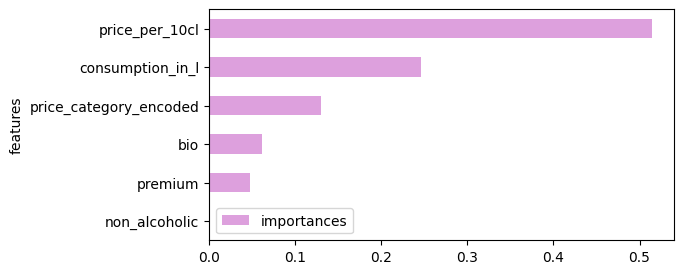

In [302]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='plum', 
           figsize=(6,3))

### Confusion Matrix Heatmap

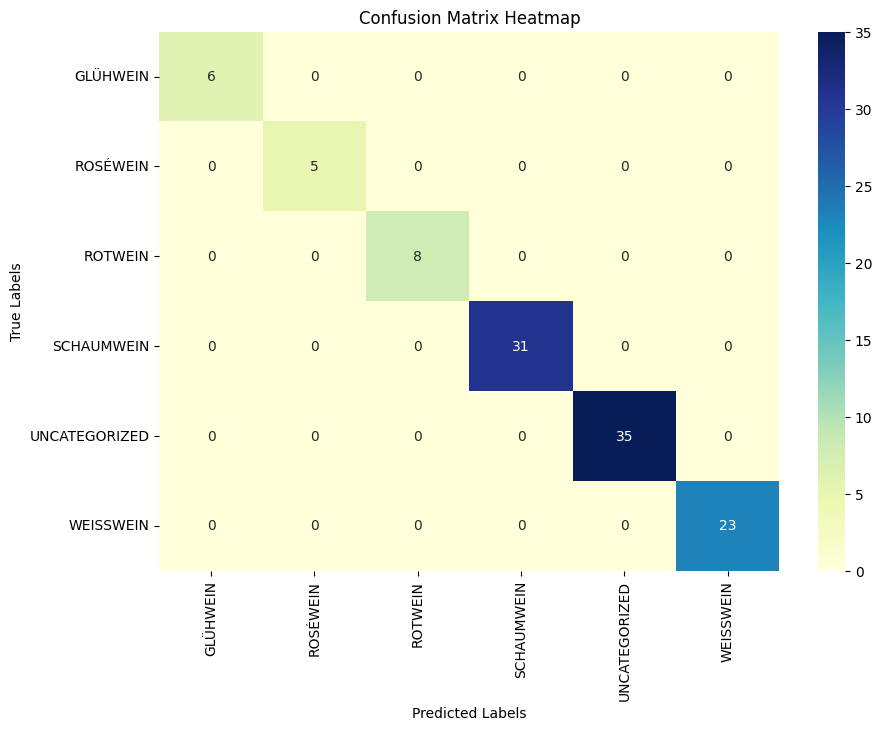

In [303]:
# Define categories
categories = ['GLÜHWEIN', 'ROSÉWEIN', 'ROTWEIN', 'SCHAUMWEIN', 'UNCATEGORIZED', 'WEISSWEIN']

# Generate confusion matrix
conf_matrix = confusion_matrix(y2_test, y_pred_rf, labels=categories)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=categories, yticklabels=categories
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()


If all off-diagonal cells are zero, your model perfectly classified all test instances into their correct categories.
The diagonal cells show the number of correct predictions for each class (e.g., 6 for GLÜHWEIN, 31 for SCHAUMWEIN).